# MNIST
- 官方实现 https://github.com/pytorch/examples/blob/main/mnist/main.py

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchsummary
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # 归一化到(0,1) 分布到(-1,1)
])
dataset1 = torchvision.datasets.MNIST(root="../../data", train=True, download=True, transform=transform)
dataset2 = torchvision.datasets.MNIST(root="../../data", train=False, download=False, transform=transform)
# DataLoader num_workers 不要设置, cpu: num_workers=2
train_loader: DataLoader = torch.utils.data.DataLoader(dataset1, batch_size=64, shuffle=True)
test_loader: DataLoader = torch.utils.data.DataLoader(dataset2, batch_size=1000, shuffle=True)

target: 5


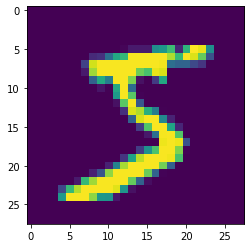

In [22]:
def imshow(img):
    plt.imshow(np.reshape(img, [28, 28]))
    plt.show()


img, val = train_loader.dataset[0]
print(f"target: {val}")
imshow(img)

In [23]:
def train(model: nn.Module, device, train_loader, optimizer: torch.optim.Optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()

        optimizer.step()

        if batch_idx % 10 == 0:
            # Train Epoch: 2 [16640/60000 (28%)]	Loss: 0.142410
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))


def test(model: nn.Module, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdims=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    # Test set: Average loss: 0.0483, Accuracy: 9849/10000 (98%)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss,
        correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

### nn.Conv2d 卷积
- 图示 https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
- in_channels: 输入的通道数目
- out_channels: 输出的通道数目
- kernel_size: w * h
- stride: 卷积每次滑动的步长为多少，默认1
- padding: 加 x 外圈边界
- dilation: kernel 每次的 偏移量，默认1，2就是跳一个

### nn.Dropout
- x % 的概率失效

### size 的 计算
- Conv2d
    - nn.Conv2d(1, 32, (3, 3), (1, 1))
    - 1, 28, 28 => 32, 26, 26
    - nn.Conv2d(32, 64, (3, 3), (1, 1))
    - 32, 26, 26 => 64, 24, 24
- max_pool2d 大步走 `2步变1步` size 小一半
    - F.max_pool2d(x, 2)
    - 64, 24, 24 => 64, 12, 12
- flatten 拍平
    - torch.flatten(x, 1)
    - 64, 12, 12 => 9216

In [30]:
class MyModel(nn.Module): # e1 99%
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5, 5), stride=(1, 1))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), stride=(1, 1))
        self.dropout1 = nn.Dropout(.25)
        self.dropout2 = nn.Dropout(.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):  # batch_size=64, 1, 28, 28
        x = self.conv1(x)  # 32, 26, 26
        x = F.relu(x)
        x = self.conv2(x)  # 64, 24, 24
        x = F.relu(x)

        x = F.max_pool2d(x, 2)  # 64, 12, 12
        x = self.dropout1(x)
        x = torch.flatten(x, 1)  # 9216
        x = self.fc1(x)  # 64, 128
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)  # 10

        x = F.log_softmax(x, dim=1)  # 10
        return x


class MyModel2(nn.Module):  # e1 86% e5 92%
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)

    def forward(self, x):  # 64, 1, 28, 28 第一个 64 是 batch_size
        x = torch.flatten(x, 1)  # 728
        x = self.fc1(x)  # 200
        x = self.fc2(x)  # 200
        x = self.fc3(x)  # 10

        x = F.log_softmax(x, dim=1)  # 10
        return x

In [25]:
model = MyModel2().to(device)

optimizer = torch.optim.Adadelta(model.parameters(), lr=1)

scheduler = StepLR(optimizer=optimizer, step_size=1, gamma=.7)

torchsummary.summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
            Linear-2                  [-1, 200]          40,200
            Linear-3                   [-1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------


In [68]:
for epoch in range(1, 1 + 5):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.292221
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.373076
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.653551
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.711813
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.457500
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.549031
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.761111
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.478221
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.513730
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.412486
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.494328
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.321828
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.379031
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.442548
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.630965
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.441282
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.456119
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.122255
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.489996
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.778697
Train Epoch: 1 [12800/60000 (

In [72]:
torch.save(model.state_dict(), 'mnist.pth')